In [4]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from py_vncorenlp import  VnCoreNLP
import py_vncorenlp
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC

In [95]:
train = pd.read_csv('/kaggle/input/balance-gold-dataset/balance_train.csv', sep=',')

In [96]:
test = pd.read_csv('/kaggle/input/balance-gold-dataset/balance_test.csv', sep=',')

In [97]:
train.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,66.50,"Lợi suất trái phiếu toàn cầu đang tăng lên, đi...",24/06/2023,67.10,08:30,Giá vàng hôm nay 24/6: Vọt lên cao rồi cắm đầu...,increase
1,67.65,Tài khoản không đủ để thực hiện chức năng này....,14/07/2022,68.25,09:00,Giá vàng hôm nay 14/7: Vàng trong nước tăng ng...,increase
2,56.75,Giá vàng hôm nay ngày 12/7/2021 biến động từ g...,12/07/2021,57.50,08:55,Giá vàng hôm nay ngày 12/7/2021: biến động nhẹ...,decrease
3,68.20,"Hôm qua, thị trường nhận thông tin về báo cáo ...",05/10/2023,68.90,09:20,Giá vàng hôm nay 5/10: Chuyên gia dự đoán lạc ...,decrease
4,74.30,Giá vàng bật tăng khi căng thẳng quân sự leo t...,30/01/2024,76.80,08:55,"Giá vàng hôm nay 30/1: Nhiều yếu tố hỗ trợ, và...",increase


In [98]:
test.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,67.85,. Sự tin tưởng của khu vực kinh doanh vào một ...,25/06/2022,68.65,09:45,"Giá vàng hôm nay 25/6: ""Hụt hơi"" phiên cuối tu...",decrease
1,82.80,Xu hướng mua ròng vàng miếng của các quốc gia ...,10/04/2024,84.80,08:20,"Giá vàng hôm nay 10/4: Sau ""cơn điên"" tăng giá...",increase
2,66.45,Mặc dù tâm lý lạc quan đã quay trở lại nhưng h...,10/07/2023,67.05,08:30,"Giá vàng hôm nay 10/7: Vàng đi ngang, giới đầu...",decrease
3,56.35,Giá vàng hôm nay ngày 5/1/2021 tăng từ 50.000 ...,05/01/2021,56.90,10:20,Giá vàng hôm nay ngày 5/1/2021: vàng tiếp tục ...,increase
4,68.80,. Giá vàng tiếp đà tăng khi thị trường tài chí...,09/06/2022,69.70,08:30,"Giá vàng hôm nay 9/6: Được hỗ trợ mạnh, vàng p...",increase


In [99]:
def get_config():
    config = {'batch_size': 8,
              'model_name': 'uitnlp/visobert',
              'lr': 10 ** -5,
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 128,
              'eos': '[SEP]'
              
    }
    return config 

In [100]:
config = get_config()

In [101]:
train['word_embedding'] = train['TITLE'] + '[SEP]' + train['CONTENT']
test['word_embedding'] = test['TITLE'] + '[SEP]' + test['CONTENT']

### Preprocessing

In [81]:
def preprocess(text):
    # Loại bỏ các ký tự xuống dòng và thay thế chúng bằng một khoảng trắng
    text = re.sub(r'\r\n+', ' ', text)
    
    # Chuẩn hóa khoảng trắng để không có nhiều khoảng trắng liên tiếp
    text = re.sub(r'\s+', ' ', text)
    
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s/]', '', text)
    
    # Thêm dấu chấm câu để tách các câu
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text)  # Thêm khoảng trắng giữa số và chữ
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)   # Thêm khoảng trắng giữa số và chữ nếu không có khoảng trắng
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)   # Thêm khoảng trắng giữa chữ và số nếu không có khoảng trắng
    text = re.sub(r'(đồng lượng|usdoz|lượng)', r'\1.', text)  # Thêm dấu chấm sau các đơn vị đo lường
    
    # Loại bỏ khoảng trắng thừa ở đầu và cuối chuỗi
    text = text.strip()

    # Chuyển thành chữ thường
    text = text.lower()

    return text

In [82]:
train['word_embedding'] = train['word_embedding'].apply(lambda x: preprocess(x))
test['word_embedding'] = test['word_embedding'].apply(lambda x: preprocess(x))

In [102]:
train['labels'] = train['labels'].apply(lambda x: 1 if x == 'increase' else 0)

In [103]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [104]:
# create model
model = AutoModel.from_pretrained(config['model_name']).to(device)

tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Creating Word Embedding 

In [105]:
def word_embedding(x):
    inputs = tokenizer(x, truncation=True, padding=True, return_tensors='pt', max_length=config['max_length']).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().cpu().numpy()[0]

In [106]:
train['word_embedding'] = train['word_embedding'].apply(lambda x: word_embedding(x))
test['word_embedding'] = test['word_embedding'].apply(lambda x: word_embedding(x))

### Training

In [107]:
svm = SVC()

In [108]:
# training
print("========== Start training ==========")
svm.fit(train['word_embedding'].values.tolist(), train['labels'].values)
print("========== End training ==========")

========== Start training ==========
========== End training ==========


In [109]:
preds = svm.predict(test['word_embedding'].values.tolist())

In [110]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [111]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [112]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.7703
Precision : 0.8028
Recall    : 0.7403
F1 Score  : 0.7703


Confusion metrics

Confusion matrix is: [[57 14]
 [20 57]]


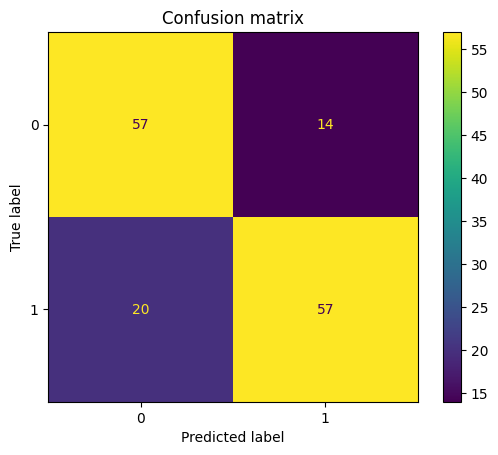

In [113]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()